# Ставить стоп лосс

А не просто выходить по закрытию

In [1]:
import pandas as pd
import yfinance as yf
import numpy as np
from tqdm.notebook import tqdm
from numpy_ext import rolling_apply

import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('../csv/SBER_101001_201201_1d.csv',
		delimiter=',',
		parse_dates=[[0,1]],
		index_col=0,
		names=['Date','Time','Open', 'High', 'Low', 'Close', 'Volume'],
		header=0,
		encoding='utf-8'
	)

In [3]:
#для статистики
stat = pd.DataFrame(columns=[
    'Data',
    'Start_Date',
    'End_Date',
    'Return_On_Account',
    #'Gross_Profit',
    #'Gross_Loss',
    'Num_Of_Trades',
    'Num_Of_Win_Trades',
    'Num_Of_Loss_Trades',
    'Percent_Profitable',
    'Largest_Win_Trade',
    'Largest_Loss_trade',
    'Avg_Win_Trade',
    'Avg_Loss_Trade',
    'Avg_Win_Avg_Loss',
    'Avg_Trade',
    'Max_Cons_Win',
    'Max_Cons_Loss',
    'Max_Drawdown',
    'Profit_Factor',
    'Sharpe_Ratio'
])

In [4]:
days = 6 # days - количество дней, цикл считает до n-1
levers = 6 # максимальное плечо, цикл считает до n-1

#стоп лоссы
buy_stop = -0.035
sell_stop = -0.02

## Подготовка данных

In [5]:
def detect_colors(df_):
    """Определяет цвета свечей
    """
    df_['Color'] = np.where(
        df_['Open']<df_['Close'],
        'Up',
        np.where(
            df_['Open']>df_['Close'],
            'Down',
            'Dodge'
        )
    )

    return df_

In [6]:
df = detect_colors(df)

In [7]:
def add_buy_and_sell(df):
    """Добавляет проценты по сделкам
    """
    buy = df[['Close']].rename(columns={"Close": "Buy"})
    buy['Buy'] = df['Close'].apply(np.log)-df['Open'].apply(np.log)
    #buy['Buy_Prev_Close'] = df['Close'].apply(np.log)-df['Close'].shift(1).apply(np.log)
    #buy['Buy_'] = (df['Close']-df['Open'])/df['Open']
    df = df.join(buy)

    sell = df[['Close']].rename(columns={"Close": "Sell"})
    sell['Sell'] = df['Open'].apply(np.log)-df['Close'].apply(np.log)
    #sell['Sell_Prev_Close'] = df['Close'].shift(1).apply(np.log)-df['Close'].apply(np.log)
    #sell['Sell_'] = (df['Open']-df['Close'])/df['Open']
    df = df.join(sell)

    return df

In [8]:
df = add_buy_and_sell(df)

In [9]:
def add_some_data(df_):
    #для трейлинг стопа
    df_['High_Open'] = df_['High'].apply(np.log)-df_['Open'].apply(np.log)
    df_['Open_Low'] = df_['Open'].apply(np.log)-df_['Low'].apply(np.log)

    #для стопа
    df_['Low_Open'] = df_['Low'].apply(np.log)-df_['Open'].apply(np.log)
    df_['Open_High'] = df_['Open'].apply(np.log)-df_['High'].apply(np.log)
    return df_

In [10]:
df = add_some_data(df)

## Разные функции

In [11]:
def calc_n_days_buy(color, buy):
    """Проверяет есть ли n дней подряд закрытия вверх.

    Args:
		color [list of str]: массив, где каждый элемент показывает цвет свечи 'Up' или 'Down'
        buy [list of float]: массив с покупками

	Returns:
		[float]: разница в % между текущей и предыдущей ценой при покупке (или NaN)
    """
    n = len(color)
    if (color[:n-1] == 'Down').all():
        return buy[-1]
    else:
        return np.nan

In [12]:
def calc_n_days_buy_take_stop(color, buy, low_open):
    """Проверяет есть ли n дней подряд закрытия вверх.

    Args:
		color [list of str]: массив, где каждый элемент показывает цвет свечи 'Up' или 'Down'
        buy [list of float]: массив с покупками

	Returns:
		[float]: разница в % между текущей и предыдущей ценой при покупке (или NaN)
    """
    n = len(color)
    if (color[:n-1] == 'Down').all():
        if (buy[-1] < buy_stop and buy_stop != 0) or \
            (low_open[-1] < buy_stop and buy_stop != 0):
            return buy_stop
        else:
            return buy[-1]
    else:
        return np.nan

In [13]:
def calc_n_days_sell(color, sell):
    """Проверяет есть ли n дней подряд закрытия вниз.

    Args:
		color [list of str]: массив, где каждый элемент показывает цвет свечи 'Up' или 'Down'
        sell [list of float]: массив с продажами

	Returns:
		[float]: разница в % между текущей и предыдущей ценой при продаже (или NaN)
    """
    n = len(color)
    if (color[:n-1] == 'Up').all():
        return sell[-1]
    else:
        return np.nan

In [14]:
def calc_n_days_sell_take_stop(color, sell, open_high):
    """Проверяет есть ли n дней подряд закрытия вниз.

    Args:
		color [list of str]: массив, где каждый элемент показывает цвет свечи 'Up' или 'Down'
        sell [list of float]: массив с продажами

	Returns:
		[float]: разница в % между текущей и предыдущей ценой при продаже (или NaN)
    """
    n = len(color)
    if (color[:n-1] == 'Up').all():
        if (sell[-1] < sell_stop and sell_stop != 0) or \
            (open_high[-1] < sell_stop and sell_stop != 0):
            return sell_stop
        else:
            return sell[-1]
    else:
        return np.nan

In [15]:
def calc_n_days_buysell(color, buy, sell):
    """Проверяет есть ли n дней подряд закрытия вверх или закрытия вниз для продаж и покупок вместе

    Args:
		color [list of str]: массив, где каждый элемент показывает цвет свечи 'Up' или 'Down'
        buy [list of float]: массив с покупками
        sell [list of float]: массив с продажами
	Returns:
		[float]: разница в % между текущей и предыдущей ценой при покупке или продаже (или NaN)
    """
    n = len(color)
    if (color[:n-1] == 'Down').all():
        return buy[-1]
    elif (color[:n-1] == 'Up').all():
        return sell[-1]
    else:
        return np.nan

In [16]:
def calc_n_days_buysell_take_stop(color, buy, sell, low_open, open_high):
    """Проверяет есть ли n дней подряд закрытия вверх или закрытия вниз для продаж и покупок вместе

    Args:
		color [list of str]: массив, где каждый элемент показывает цвет свечи 'Up' или 'Down'
        buy [list of float]: массив с покупками
        sell [list of float]: массив с продажами
	Returns:
		[float]: разница в % между текущей и предыдущей ценой при покупке или продаже (или NaN)
    """
    n = len(color)
    if (color[:n-1] == 'Down').all():
        if (buy[-1] < buy_stop and buy_stop != 0) or \
            (low_open[-1] < buy_stop and buy_stop != 0):
            return buy_stop
        else:
            return buy[-1]
    elif (color[:n-1] == 'Up').all():
        if (sell[-1] < sell_stop and sell_stop != 0) or \
            (open_high[-1] < sell_stop and sell_stop != 0):
            return sell_stop
        else:
            return sell[-1]
    else:
        return np.nan

In [17]:
def calc_stat(df_, stat_, days, levers):
    """Cчитает статистику по каждой стратегии

    Определения брал отсюда https://www.investopedia.com/articles/fundamental-analysis/10/strategy-performance-reports.asp
    Args:
	    df_ [dataframe]: массив со сделками
        stat_ [dataframe]: массив со стистикой
        days [int]: максимальное количество дней в в рассчётах
        levers [int]: максимальные рычаг в рассчётах
	Returns:
		[float]: разница в % между текущей и предыдущей ценой при покупке или продаже (или NaN)
    """
    
    directions = ['Buy', 'Sell', 'Buysell']
    for day in range(1, days):
        for lever in range(1, levers):
            for direction in directions:
                trades = '{}_{}_Days_Lever_{}_Commiss'.format(direction, day, lever)
                ret = 'Return_{}_{}_Days_Lever_{}_Commiss'.format(direction, day, lever)

                data = 'SBER'
                start_date = df_[trades].index[0].strftime("%Y-%m-%d")
                end_date = df_[trades].index[-1].strftime("%Y-%m-%d")
                return_on_account = df_[ret].dropna().iloc[-1]
                num_of_trades = df_[ret].dropna().count()
                num_of_win_trades = (df_[trades]>0).sum()
                num_of_loss_trades = (df_[trades]<0).sum()
                percent_profitable = num_of_win_trades/num_of_trades
                largest_win_trade = df_[df_[trades]>0][trades].max()
                largest_loss_trade = df_[df_[trades]<0][trades].min()
                avg_win_trade = df_[df_[trades]>0][trades].mean()
                avg_loss_trade = df_[df_[trades]<0][trades].mean()
                avg_win_avg_loss = abs(avg_win_trade/avg_loss_trade)
                avg_trade = return_on_account/num_of_trades
                
                #max_cons_win https://stackoverflow.com/questions/52717996/how-can-i-count-the-number-of-consecutive-trues-in-a-dataframe
                ge_0 = df_[trades].dropna().ge(0)
                ge_0_cumsum = ge_0.cumsum()
                max_cons_win = ge_0_cumsum.sub(ge_0_cumsum.mask(ge_0).ffill().fillna(0)).astype(int).max()
                
                #max_cons_loss
                le_0 = df_[trades].dropna().le(0)
                le_0_cumsum = le_0.cumsum()
                max_cons_loss = le_0_cumsum.sub(le_0_cumsum.mask(le_0).ffill().fillna(0)).astype(int).max()

                max_drowdown = df_[ret].dropna().div(df_[ret].dropna().cummax()).subtract(1).min()

                #profit_factor
                diff = df_[ret].dropna().diff(1)
                gross_profit = diff[diff.ge(0)].sum()
                gross_loss = abs(diff[diff.le(0)].sum())
                profit_factor = gross_profit/gross_loss

                #https://quant.stackexchange.com/questions/39839/how-to-calculate-sharpe-ratio-from-returns
                sharpe_ratio = (df_[trades].mean()/df_[trades].std())*np.sqrt(252)
                
                #stat_.loc[len(stat_)] = [
                stat_.loc[trades] = [
                    data,
                    start_date,
                    end_date,
                    return_on_account,
                    num_of_trades,
                    num_of_win_trades,
                    num_of_loss_trades,
                    percent_profitable,
                    largest_win_trade,
                    largest_loss_trade,
                    avg_win_trade,
                    avg_loss_trade,
                    avg_win_avg_loss,
                    avg_trade,
                    max_cons_win,
                    max_cons_loss,
                    max_drowdown,
                    profit_factor,
                    sharpe_ratio
                ]

    return stat_

In [18]:
def calc_stat_take_stop(df_, stat_, days, levers):
    """Cчитает статистику по каждой стратегии

    Определения брал отсюда https://www.investopedia.com/articles/fundamental-analysis/10/strategy-performance-reports.asp
    Args:
	    df_ [dataframe]: массив со сделками
        stat_ [dataframe]: массив со стистикой
        days [int]: максимальное количество дней в в рассчётах
        levers [int]: максимальные рычаг в рассчётах
	Returns:
		[float]: разница в % между текущей и предыдущей ценой при покупке или продаже (или NaN)
    """
    
    directions = ['Buy', 'Sell', 'Buysell']
    for day in range(1, days):
        for lever in range(1, levers):
            for direction in directions:
                trades = '{}_{}_Days_TS_Lever_{}_Commiss'.format(direction, day, lever)
                ret = 'Return_{}_{}_Days_TS_Lever_{}_Commiss'.format(direction, day, lever)

                data = 'SBER'
                start_date = df_[trades].index[0].strftime("%Y-%m-%d")
                end_date = df_[trades].index[-1].strftime("%Y-%m-%d")
                return_on_account = df_[ret].dropna().iloc[-1]
                num_of_trades = df_[ret].dropna().count()
                num_of_win_trades = (df_[trades]>0).sum()
                num_of_loss_trades = (df_[trades]<0).sum()
                percent_profitable = num_of_win_trades/num_of_trades
                largest_win_trade = df_[df_[trades]>0][trades].max()
                largest_loss_trade = df_[df_[trades]<0][trades].min()
                avg_win_trade = df_[df_[trades]>0][trades].mean()
                avg_loss_trade = df_[df_[trades]<0][trades].mean()
                avg_win_avg_loss = abs(avg_win_trade/avg_loss_trade)
                avg_trade = return_on_account/num_of_trades
                
                #max_cons_win https://stackoverflow.com/questions/52717996/how-can-i-count-the-number-of-consecutive-trues-in-a-dataframe
                ge_0 = df_[trades].dropna().ge(0)
                ge_0_cumsum = ge_0.cumsum()
                max_cons_win = ge_0_cumsum.sub(ge_0_cumsum.mask(ge_0).ffill().fillna(0)).astype(int).max()
                
                #max_cons_loss
                le_0 = df_[trades].dropna().le(0)
                le_0_cumsum = le_0.cumsum()
                max_cons_loss = le_0_cumsum.sub(le_0_cumsum.mask(le_0).ffill().fillna(0)).astype(int).max()

                max_drowdown = df_[ret].dropna().div(df_[ret].dropna().cummax()).subtract(1).min()

                #profit_factor
                diff = df_[ret].dropna().diff(1)
                gross_profit = diff[diff.ge(0)].sum()
                gross_loss = abs(diff[diff.le(0)].sum())
                profit_factor = gross_profit/gross_loss

                #https://quant.stackexchange.com/questions/39839/how-to-calculate-sharpe-ratio-from-returns
                sharpe_ratio = (df_[trades].mean()/df_[trades].std())*np.sqrt(252)
                
                #stat_.loc[len(stat_)] = [
                stat_.loc[trades] = [
                    data,
                    start_date,
                    end_date,
                    return_on_account,
                    num_of_trades,
                    num_of_win_trades,
                    num_of_loss_trades,
                    percent_profitable,
                    largest_win_trade,
                    largest_loss_trade,
                    avg_win_trade,
                    avg_loss_trade,
                    avg_win_avg_loss,
                    avg_trade,
                    max_cons_win,
                    max_cons_loss,
                    max_drowdown,
                    profit_factor,
                    sharpe_ratio
                ]

    return stat_

## Основной цикл

In [19]:
def direct_take_stop(df, commission, days, levers):
    min_take = 0.01 #уровень минимальной прибыли
    for n in tqdm(range(1,days)):
        buy_n_days = 'Buy_'+str(n)+'_Days_TS'
        sell_n_days = 'Sell_'+str(n)+'_Days_TS'
        buysell_n_days = 'Buysell_'+str(n)+'_Days_TS'

        #df[buy_n_days] = rolling_apply(calc_n_days_buy, n+1, df.Color.values, df.Buy.values)
        df[buy_n_days] = rolling_apply(calc_n_days_buy_take_stop, n+1, df.Color.values, df.Buy.values, df.Low_Open.values)
        #df[sell_n_days] = rolling_apply(calc_n_days_sell, n+1, df.Color.values, df.Sell.values)
        df[sell_n_days] = rolling_apply(calc_n_days_sell_take_stop, n+1, df.Color.values, df.Sell.values, df.Open_High.values)
        #df[buysell_n_days] = rolling_apply(calc_n_days_buysell, n+1, df.Color.values, df.Buy.values, df.Sell.values)
        df[buysell_n_days] = rolling_apply(calc_n_days_buysell_take_stop, n+1, df.Color.values, df.Buy.values, df.Sell.values, df.Low_Open.values, df.Open_High.values)

        #Плечо
        for lever in range(1,levers):
            #для сделок без комиссий
            buy_n_days_lever = buy_n_days+'_Lever_'+str(lever)
            sell_n_days_lever = sell_n_days+'_Lever_'+str(lever)
            buysell_n_days_lever = buysell_n_days+'_Lever_'+str(lever)

            return_buy_n_days_lever = 'Return_'+buy_n_days_lever
            return_sell_n_days_lever = 'Return_'+sell_n_days_lever
            return_buysell_n_days_lever = 'Return_'+buysell_n_days_lever

            #сделки с плечом и без комиссий
            df[buy_n_days_lever] = df[buy_n_days]*lever
            df[sell_n_days_lever] = df[sell_n_days]*lever
            df[buysell_n_days_lever] = df[buysell_n_days]*lever

            #ретурн c плечом и без комиссий
            df[return_buy_n_days_lever] = df[buy_n_days_lever].cumsum().apply(np.exp)
            df[return_sell_n_days_lever] = df[sell_n_days_lever].cumsum().apply(np.exp)
            df[return_buysell_n_days_lever] = df[buysell_n_days_lever].cumsum().apply(np.exp)

            #для сделок с комиссиями
            buy_n_days_lever_commiss = buy_n_days_lever+'_Commiss'
            sell_n_days_lever_commiss = sell_n_days_lever+'_Commiss'
            buysell_n_days_lever_commiss = buysell_n_days_lever+'_Commiss'

            return_buy_n_days_lever_commiss = 'Return_'+buy_n_days_lever_commiss
            return_sell_n_days_lever_commiss = 'Return_'+sell_n_days_lever_commiss
            return_buysell_n_days_lever_commiss = 'Return_'+buysell_n_days_lever_commiss

            #сделки с плечом и комиссиями
            df[buy_n_days_lever_commiss] = lever*(df[buy_n_days]-commission/100*2)
            df[sell_n_days_lever_commiss] = lever*(df[sell_n_days]-commission/100*2)
            df[buysell_n_days_lever_commiss] = lever*(df[buysell_n_days]-commission/100*2)
            
            #ретурн с плечом и комиссиями
            df[return_buy_n_days_lever_commiss] = df[buy_n_days_lever_commiss].cumsum().apply(np.exp)
            df[return_sell_n_days_lever_commiss] = df[sell_n_days_lever_commiss].cumsum().apply(np.exp)
            df[return_buysell_n_days_lever_commiss] = df[buysell_n_days_lever_commiss].cumsum().apply(np.exp)

    return df

In [20]:
def direct(df, commission, days, levers):
    for n in tqdm(range(1,days)):
        buy_n_days = 'Buy_'+str(n)+'_Days'
        sell_n_days = 'Sell_'+str(n)+'_Days'
        buysell_n_days = 'Buysell_'+str(n)+'_Days'

        df[buy_n_days] = rolling_apply(calc_n_days_buy, n+1, df.Color.values, df.Buy.values)
        df[sell_n_days] = rolling_apply(calc_n_days_sell, n+1, df.Color.values, df.Sell.values)
        df[buysell_n_days] = rolling_apply(calc_n_days_buysell, n+1, df.Color.values, df.Buy.values, df.Sell.values)

        #Плечо
        for lever in range(1,levers):
            #для сделок без комиссий
            buy_n_days_lever = buy_n_days+'_Lever_'+str(lever)
            sell_n_days_lever = sell_n_days+'_Lever_'+str(lever)
            buysell_n_days_lever = buysell_n_days+'_Lever_'+str(lever)

            return_buy_n_days_lever = 'Return_'+buy_n_days_lever
            return_sell_n_days_lever = 'Return_'+sell_n_days_lever
            return_buysell_n_days_lever = 'Return_'+buysell_n_days_lever

            #сделки с плечом и без комиссий
            df[buy_n_days_lever] = df[buy_n_days]*lever
            df[sell_n_days_lever] = df[sell_n_days]*lever
            df[buysell_n_days_lever] = df[buysell_n_days]*lever

            #ретурн c плечом и без комиссий
            df[return_buy_n_days_lever] = df[buy_n_days_lever].cumsum().apply(np.exp)
            df[return_sell_n_days_lever] = df[sell_n_days_lever].cumsum().apply(np.exp)
            df[return_buysell_n_days_lever] = df[buysell_n_days_lever].cumsum().apply(np.exp)

            #для сделок с комиссиями
            buy_n_days_lever_commiss = buy_n_days_lever+'_Commiss'
            sell_n_days_lever_commiss = sell_n_days_lever+'_Commiss'
            buysell_n_days_lever_commiss = buysell_n_days_lever+'_Commiss'

            return_buy_n_days_lever_commiss = 'Return_'+buy_n_days_lever_commiss
            return_sell_n_days_lever_commiss = 'Return_'+sell_n_days_lever_commiss
            return_buysell_n_days_lever_commiss = 'Return_'+buysell_n_days_lever_commiss

            #сделки с плечом и комиссиями
            df[buy_n_days_lever_commiss] = lever*(df[buy_n_days]-commission/100*2)
            df[sell_n_days_lever_commiss] = lever*(df[sell_n_days]-commission/100*2)
            df[buysell_n_days_lever_commiss] = lever*(df[buysell_n_days]-commission/100*2)
            
            #ретурн с плечом и комиссиями
            df[return_buy_n_days_lever_commiss] = df[buy_n_days_lever_commiss].cumsum().apply(np.exp)
            df[return_sell_n_days_lever_commiss] = df[sell_n_days_lever_commiss].cumsum().apply(np.exp)
            df[return_buysell_n_days_lever_commiss] = df[buysell_n_days_lever_commiss].cumsum().apply(np.exp)

    return df

In [21]:
def main_loop(df, stat):
    commission = 0.06
    #days = 6 # days - количество дней, цикл считает до n-1
    #levers = 6 # максимальное плечо, цикл считает до n-1
    df = direct(df, commission, days, levers)
    df = direct_take_stop(df, commission, days, levers)
    stat = calc_stat(df, stat, days, levers)
    stat = calc_stat_take_stop(df, stat, days, levers)
    
    return df, stat

In [22]:
df, stat = main_loop(df, stat)

## Стоп лосс

In [23]:
strategy = 'Buysell_4_Days_Lever_1'

Buysell_4_Days_Lever_1 = df[df[strategy].notna()]
Buysell_4_Days_Lever_1_Buy = Buysell_4_Days_Lever_1[Buysell_4_Days_Lever_1['Buy'] == Buysell_4_Days_Lever_1[strategy]]
Buysell_4_Days_Lever_1_Sell = Buysell_4_Days_Lever_1[Buysell_4_Days_Lever_1['Sell'] == Buysell_4_Days_Lever_1[strategy]]

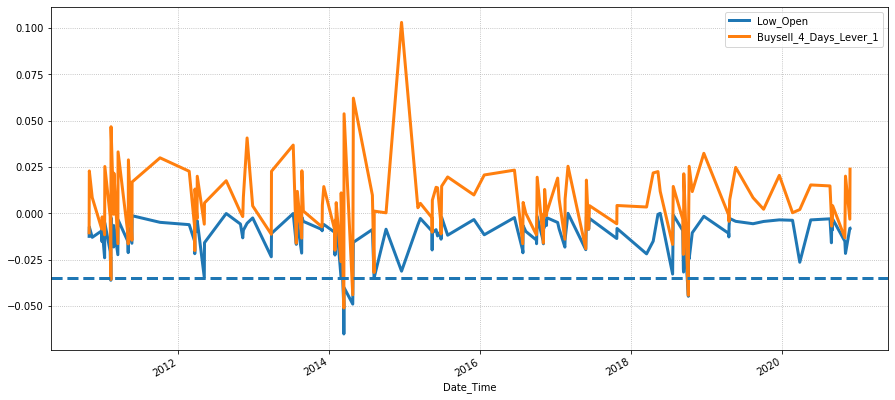

In [63]:
fig, ax = plt.subplots(figsize=(15,7))
Buysell_4_Days_Lever_1_Buy[['Low_Open']].plot(ax=ax)
Buysell_4_Days_Lever_1_Buy[[strategy]].plot(ax=ax)
plt.axhline(-0.035,linestyle='--')
plt.savefig('../src/buysell_4_days_lever_1_sber_buy_deals.png')

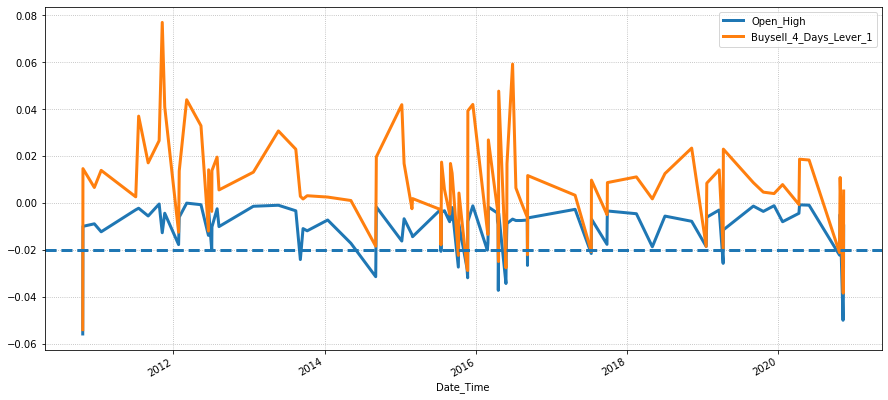

In [64]:
fig, ax = plt.subplots(figsize=(15,7))
Buysell_4_Days_Lever_1_Sell[['Open_High']].plot(ax=ax)
Buysell_4_Days_Lever_1_Sell[[strategy]].plot(ax=ax)
plt.axhline(-0.02,linestyle='--')
plt.savefig('../src/buysell_4_days_lever_1_sber_sell_deals.png')

## Графики

In [26]:
plt.rcParams['lines.linewidth'] = 3
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.linestyle'] = ':'
plt.rcParams['figure.constrained_layout.use'] = True

In [27]:
def draw(direction):
    min_days = 3
    fig, ax = plt.subplots(2, 3, figsize=(19,9))
    for lever in range(1, levers):
        for day in range(min_days, days):
            ret = 'Return_{}_{}_Days_Lever_{}_Commiss'.format(direction, day, lever)
            plt.subplot(2,3,lever)
            df[ret].interpolate(method='index').plot(ax=plt.gca(), title='Lever {}'.format(lever), legend=True)
    plt.tight_layout()
    plt.show()

In [28]:
def draw_take_stop(direction):
    min_days = 3
    fig, ax = plt.subplots(2, 3, figsize=(19,9))
    for lever in range(1, levers):
        for day in range(min_days, days):
            ret = 'Return_{}_{}_Days_TS_Lever_{}_Commiss'.format(direction, day, lever)
            plt.subplot(2,3,lever)
            df[ret].interpolate(method='index').plot(ax=plt.gca(), title='Lever {}'.format(lever), legend=True)
    plt.tight_layout()
    plt.show()

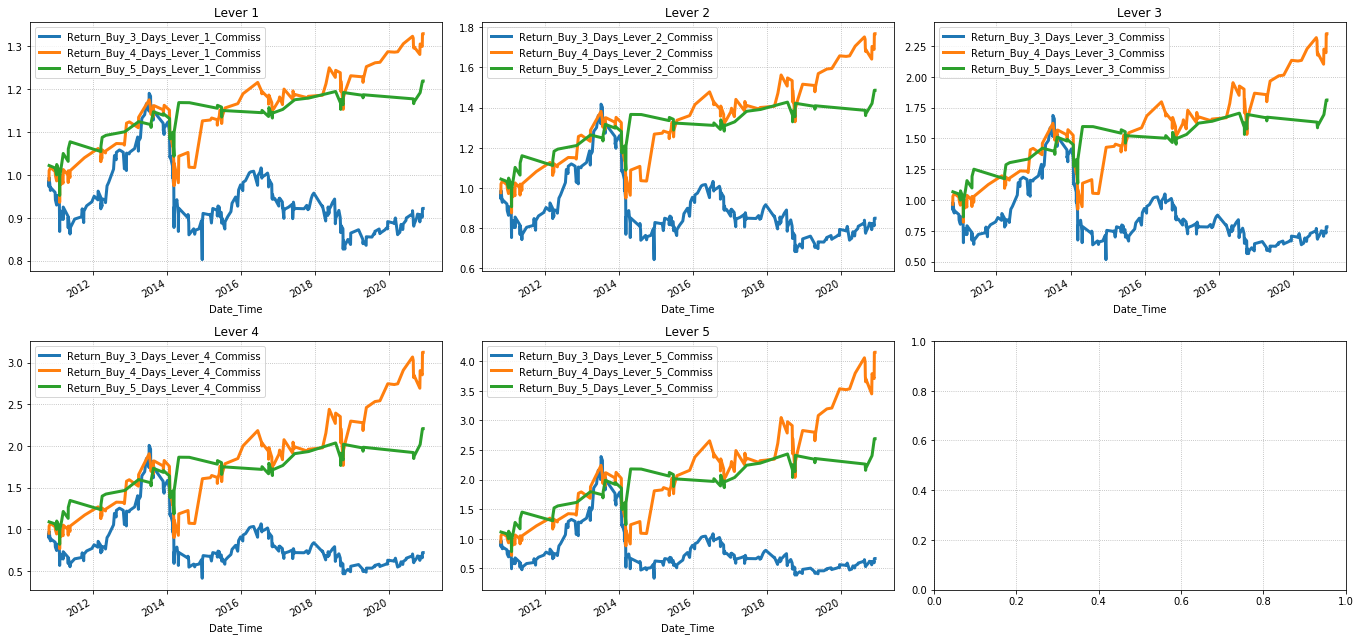

In [29]:
draw('Buy')

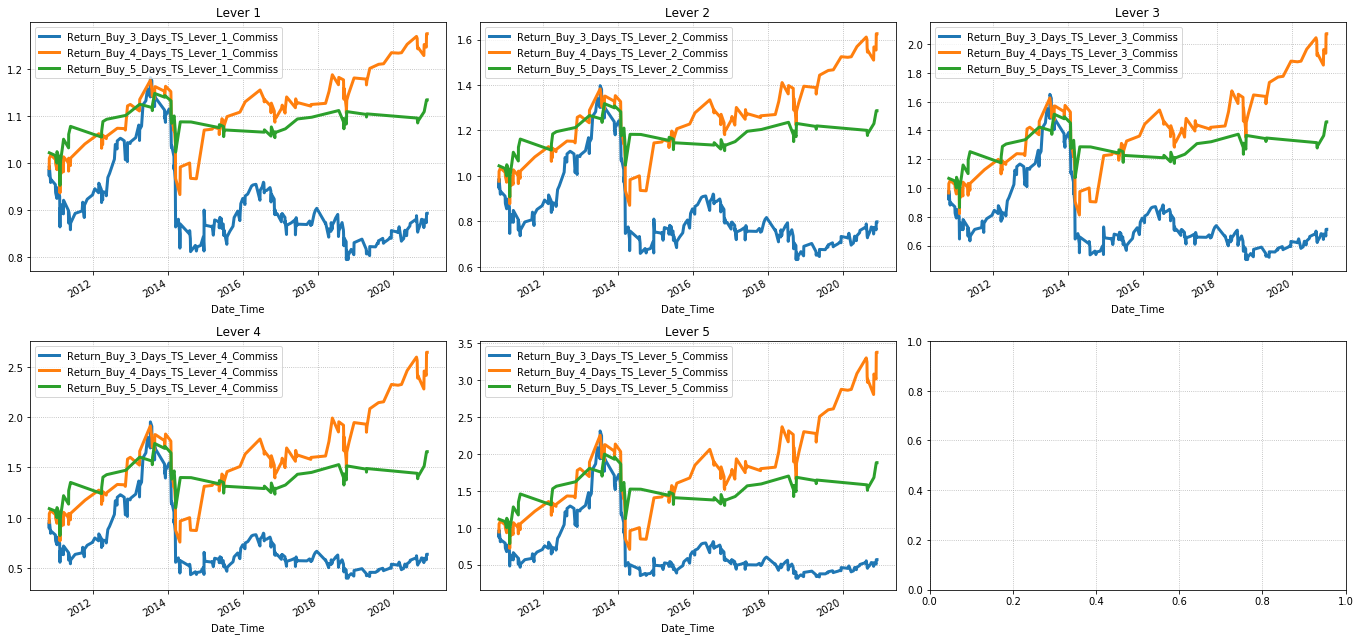

In [30]:
draw_take_stop('Buy')

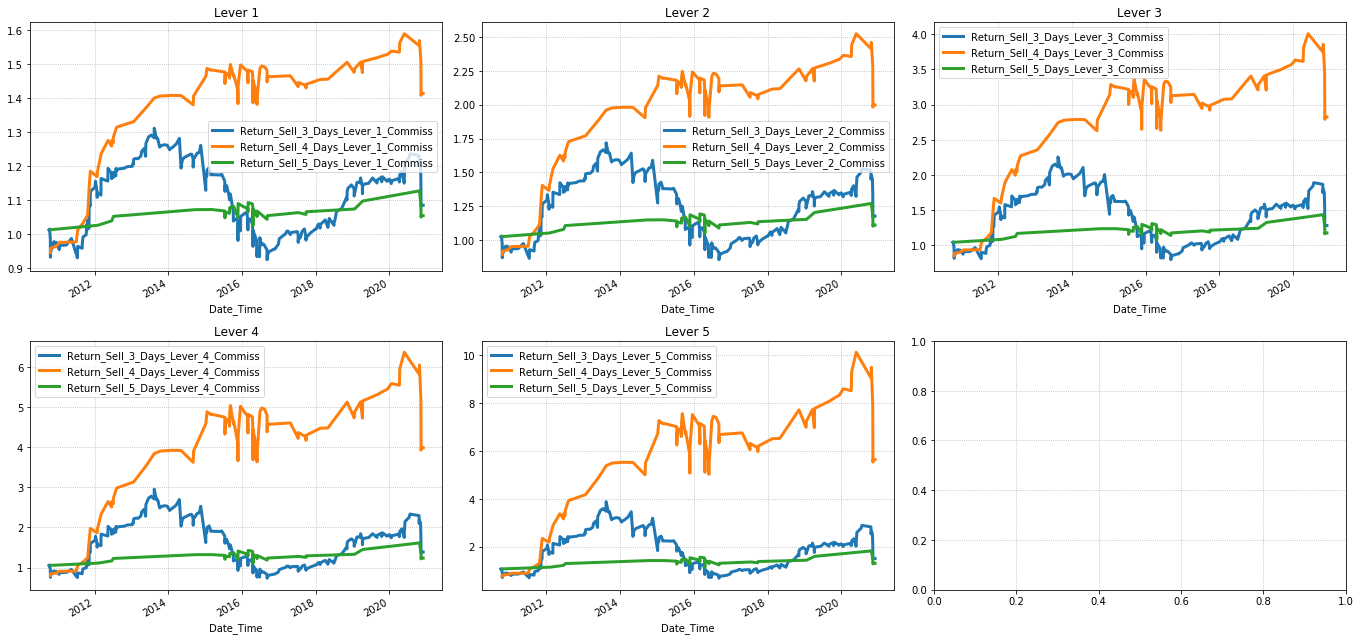

In [31]:
draw('Sell')

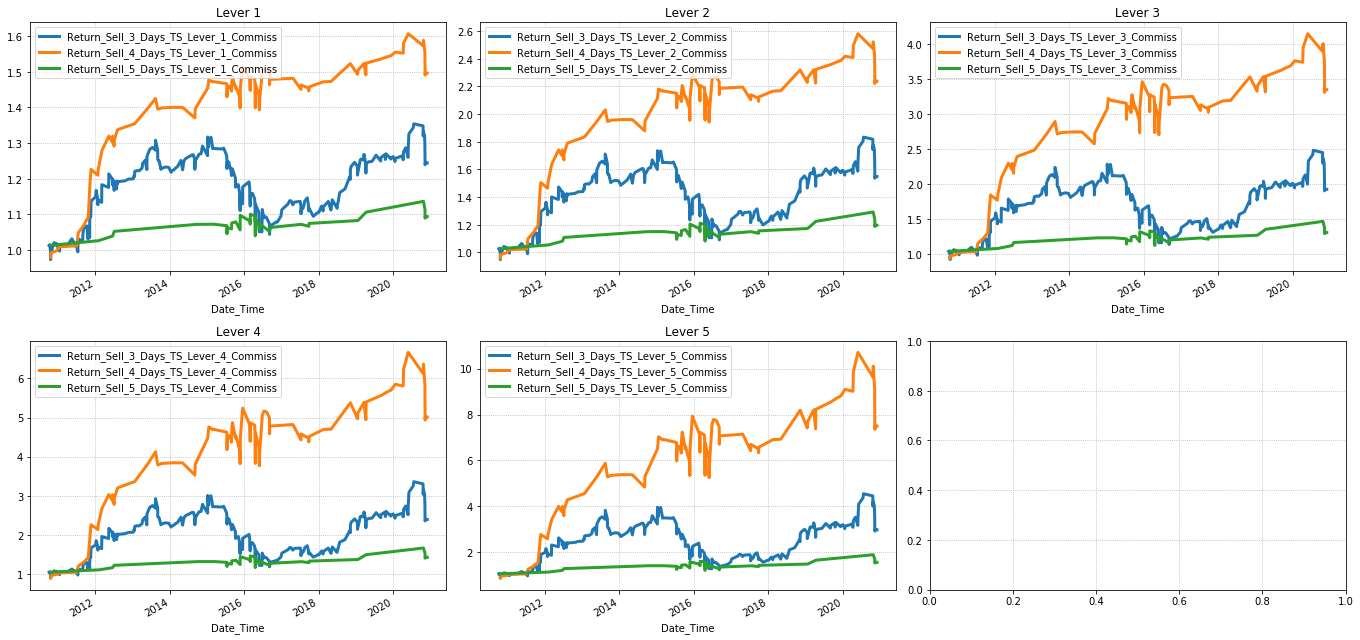

In [32]:
draw_take_stop('Sell')

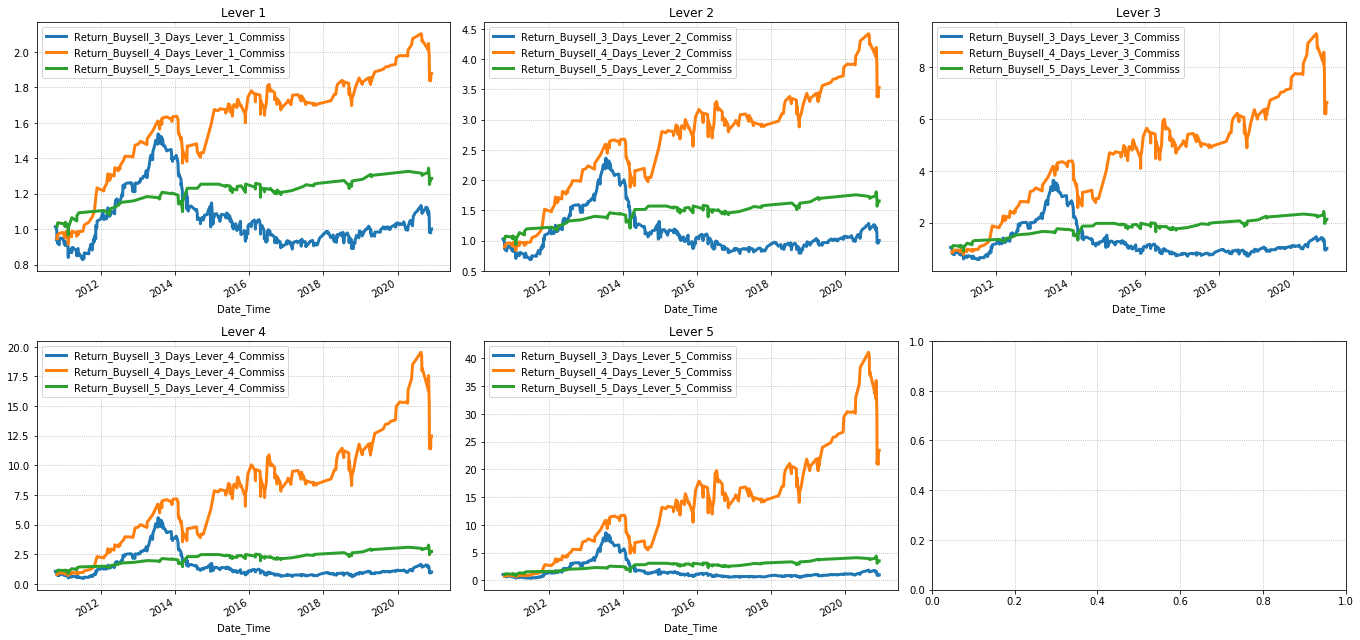

In [33]:
draw('Buysell')

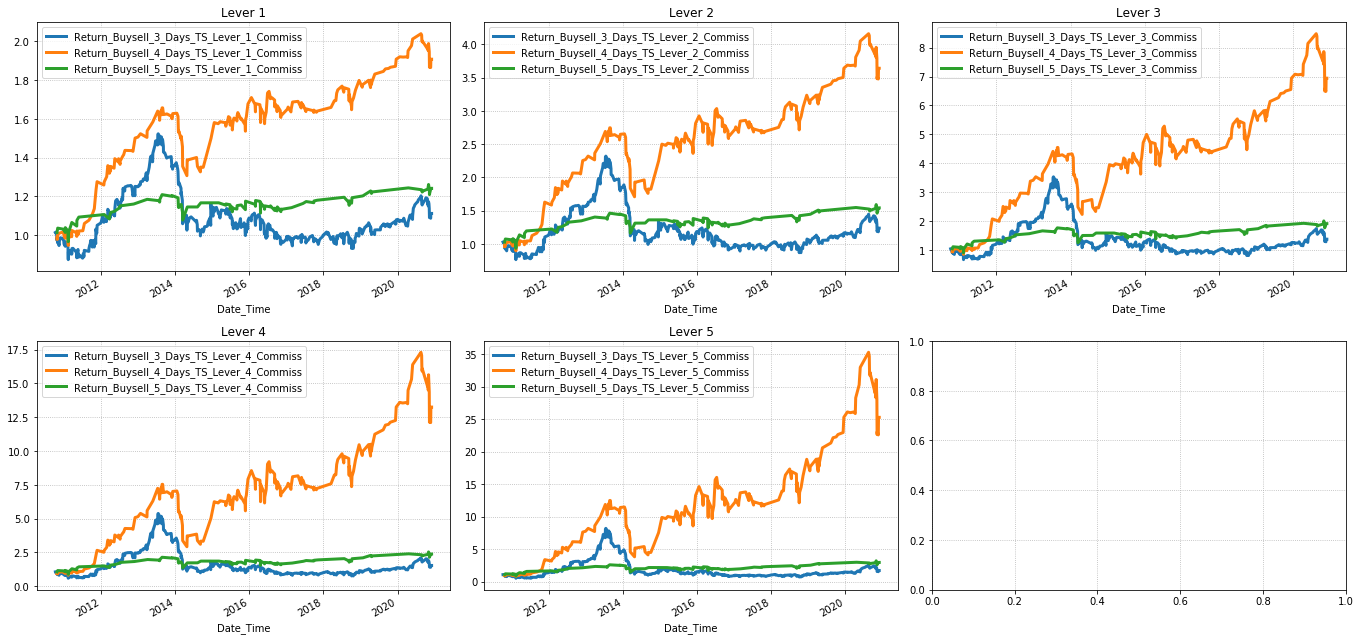

In [34]:
draw_take_stop('Buysell')

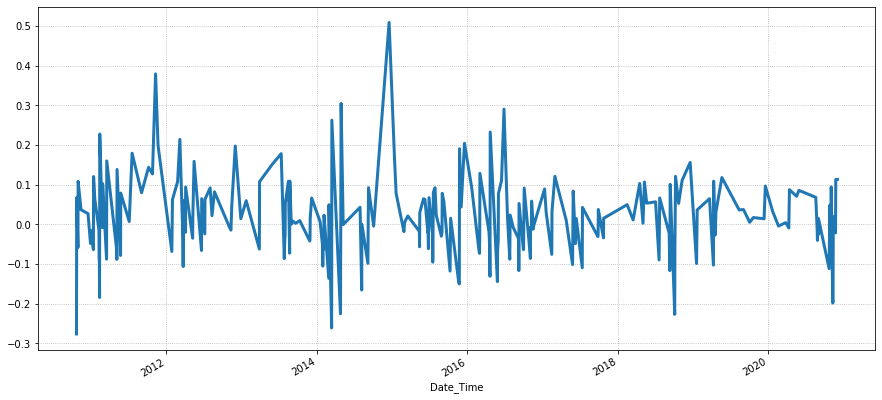

In [70]:
df['Buysell_4_Days_Lever_5_Commiss'].interpolate(method='index').plot(figsize=(15,7))
plt.savefig('../src/buysell_4_days_lever_5_sber_deals.png')

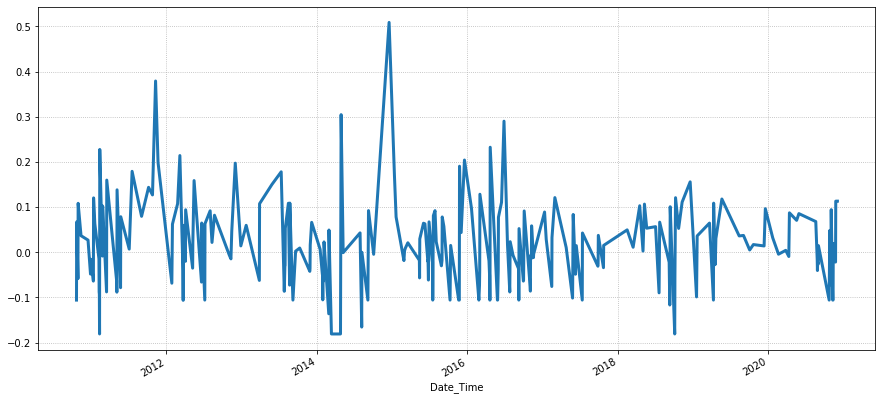

In [69]:
df['Buysell_4_Days_TS_Lever_5_Commiss'].interpolate(method='index').plot(figsize=(15,7))
plt.savefig('../src/buysell_4_days_lever_5_stop_sber_deals.png')

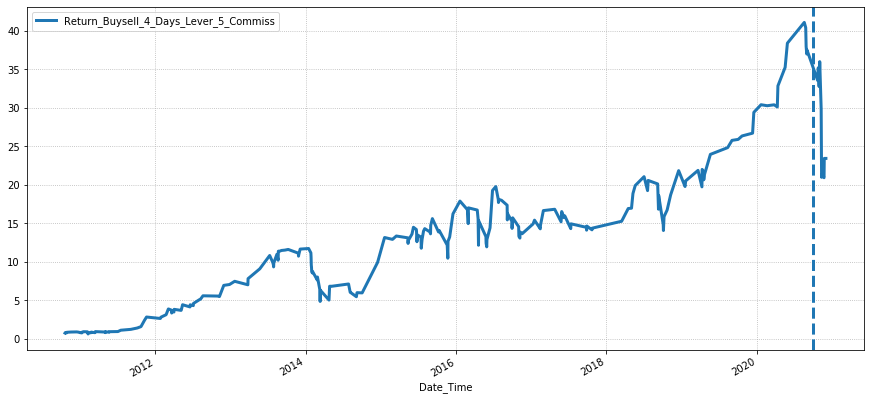

In [65]:
df[['Return_Buysell_4_Days_Lever_5_Commiss']].interpolate(method='index').plot(figsize=(15,7))
plt.axvline('2020-09-30',linestyle='--')
plt.savefig('../src/buysell_4_days_lever_5_sber.png')

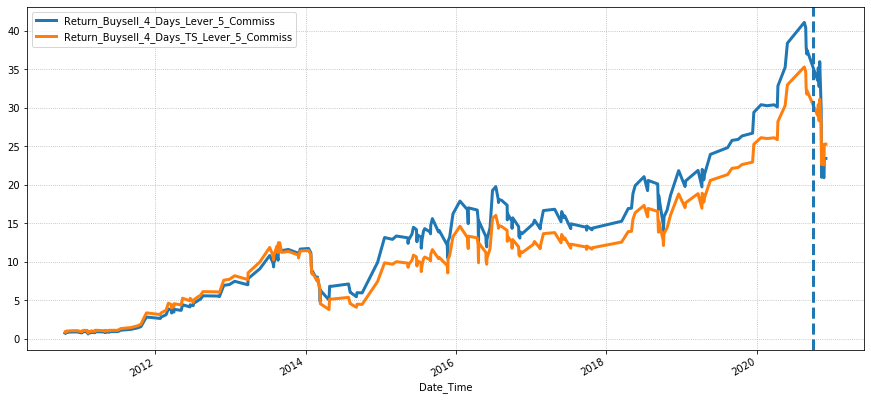

In [71]:
df[['Return_Buysell_4_Days_Lever_5_Commiss','Return_Buysell_4_Days_TS_Lever_5_Commiss']].interpolate(method='index').plot(figsize=(15,7))
plt.axvline('2020-09-30',linestyle='--')
plt.savefig('../src/buysell_4_days_lever_5_sber_stop_vs_nonstop.png')

## Статистика

In [45]:
list = [
    'Buysell_4_Days_Lever_5_Commiss',
    'Buysell_4_Days_TS_Lever_5_Commiss'
]

stat.loc[list]

,Data,Start_Date,End_Date,Return_On_Account,Num_Of_Trades,Num_Of_Win_Trades,Num_Of_Loss_Trades,Percent_Profitable,Largest_Win_Trade,Largest_Loss_trade,Avg_Win_Trade,Avg_Loss_Trade,Avg_Win_Avg_Loss,Avg_Trade,Max_Cons_Win,Max_Cons_Loss,Max_Drawdown,Profit_Factor,Sharpe_ratio
Buysell_4_Days_Lever_5_Commiss,SBER,2010-10-01,2020-12-02,23.417090,243,128,115,0.526749,0.50876,-0.276471,0.084855,-0.067026,1.266006,0.096367,9,6,-0.585873,1.235467,1.997869
Buysell_4_Days_TS_Lever_5_Commiss,SBER,2010-10-01,2020-12-02,25.269693,243,126,117,0.518519,0.50876,-0.181000,0.084055,-0.062918,1.335958,0.103991,9,6,-0.694876,1.313220,2.164357
